# 오버워치 2 점수판 분석 AI

In [1]:
import pandas as pd
from os import path
import joblib

players = 10


def prepare_scoreboards(defeat_, victory_):
    scoreboards_ = pd.concat([defeat_, victory_])
    scoreboards_.set_index(
        pd.Index((i, j) for i in range(len(scoreboards_.index) // players) for j in range(players)), inplace=True
    )
    return scoreboards_


datapath = path.join('datasets', '')
range_ = range(3, 10)
defeat = pd.read_csv(datapath + 'defeat.csv', usecols=range_)
victory = pd.read_csv(datapath + 'victory.csv', usecols=range_)
scoreboards = prepare_scoreboards(defeat, victory)
d_max = scoreboards['D'].max()
joblib.dump(d_max, 'max.joblib')
scoreboards.loc[
    (
            scoreboards['E'] == 0
    ) & (
            scoreboards['A'] == 0
    ) & (
            scoreboards['D'] == 0
    ) & (
            scoreboards['DMG'] == 0
    ) & (
            scoreboards['H'] == 0
    ) & (
            scoreboards['MIT'] == 0
    ), 'D'
] = d_max
scoreboards

E   A   D    DMG      H   MIT     GAME
0   0   7   3   6   5933   1068  6199   DEFEAT
    1   7   0  10   3601    747     0   DEFEAT
    2   9   1   6   4352      0     0   DEFEAT
    3   7   7   2   2332   6325     0   DEFEAT
    4   6   4   2   3410   5979   606   DEFEAT
...    ..  ..  ..    ...    ...   ...      ...
569 5  19   4   8  11908    505  6656  VICTORY
    6  21   1   8   9786      0    51  VICTORY
    7  20   5  11  13060      0     0  VICTORY
    8  21  17   6  10272  15807     0  VICTORY
    9  14  16  12   4702  11242  1129  VICTORY

[5700 rows x 7 columns]

In [2]:
scoreboards.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5700 entries, (0, 0) to (569, 9)
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E       5700 non-null   int64 
 1   A       5700 non-null   int64 
 2   D       5700 non-null   int64 
 3   DMG     5700 non-null   int64 
 4   H       5700 non-null   int64 
 5   MIT     5700 non-null   int64 
 6   GAME    5700 non-null   object
dtypes: int64(6), object(1)
memory usage: 349.4+ KB


In [3]:
scoreboards.describe()

,E,A,D,DMG,H,MIT
count,5700.000000,5700.000000,5700.000000,5700.000000,5700.000000,5700.000000
mean,13.962807,7.348246,6.469825,6285.321754,3847.856140,2376.922281
std,9.496484,8.165808,3.803237,4276.566264,5015.451306,4597.730128
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,4.000000,2831.750000,0.000000,0.000000
50%,13.000000,4.000000,6.000000,5608.500000,799.500000,374.000000
75%,20.000000,12.000000,9.000000,9219.000000,7474.250000,2034.250000
max,58.000000,54.000000,21.000000,26666.000000,27756.000000,41849.000000


In [4]:
import matplotlib as mpl
import os
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
IMAGES_PATH = path.join('.', 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('그림 저장:' + fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

In [5]:
scoreboards

E   A   D    DMG      H   MIT     GAME
0   0   7   3   6   5933   1068  6199   DEFEAT
    1   7   0  10   3601    747     0   DEFEAT
    2   9   1   6   4352      0     0   DEFEAT
    3   7   7   2   2332   6325     0   DEFEAT
    4   6   4   2   3410   5979   606   DEFEAT
...    ..  ..  ..    ...    ...   ...      ...
569 5  19   4   8  11908    505  6656  VICTORY
    6  21   1   8   9786      0    51  VICTORY
    7  20   5  11  13060      0     0  VICTORY
    8  21  17   6  10272  15807     0  VICTORY
    9  14  16  12   4702  11242  1129  VICTORY

[5700 rows x 7 columns]

In [6]:
tank = pd.concat([scoreboards[::players], scoreboards[5::players]])
damage = pd.concat([scoreboards[1::players], scoreboards[2::players], scoreboards[6::players], scoreboards[7::players]])
support = pd.concat(
    [scoreboards[3::players], scoreboards[4::players], scoreboards[8::players], scoreboards[9::players]]
)

In [7]:
tank.describe()

,E,A,D,DMG,H,MIT
count,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000
mean,17.924561,4.327193,6.177193,9158.353509,416.915789,9599.330702
std,10.040371,3.716106,3.669417,4065.980974,1137.400265,6045.914806
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,1.000000,4.000000,6147.250000,0.000000,5301.500000
50%,17.000000,3.000000,6.000000,9007.000000,0.000000,8506.000000
75%,24.000000,6.000000,8.000000,11728.000000,128.500000,12766.250000
max,58.000000,24.000000,21.000000,24682.000000,15168.000000,41849.000000


In [8]:
damage.describe()

,E,A,D,DMG,H,MIT
count,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000
mean,17.223684,1.932018,7.190351,8263.519298,340.360088,628.703070
std,9.102361,2.583274,4.038396,3631.156577,545.028657,1109.320861
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,0.000000,4.000000,5621.250000,0.000000,0.000000
50%,17.000000,1.000000,7.000000,7906.000000,1.000000,81.500000
75%,23.000000,3.000000,10.000000,10565.000000,515.500000,807.000000
max,52.000000,18.000000,21.000000,26666.000000,3353.000000,9682.000000


In [9]:
support.describe()

,E,A,D,DMG,H,MIT
count,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000
mean,8.721053,14.275000,5.895614,2870.608333,9070.822368,513.937281
std,6.804761,8.441279,3.498709,2139.504607,4058.607219,860.069529
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,8.000000,3.000000,1308.000000,6141.000000,0.000000
50%,8.000000,14.000000,6.000000,2552.000000,8656.000000,212.500000
75%,13.000000,19.000000,8.000000,3915.000000,11510.750000,637.250000
max,52.000000,54.000000,21.000000,16254.000000,27756.000000,7778.000000


그림 저장:tank_hist


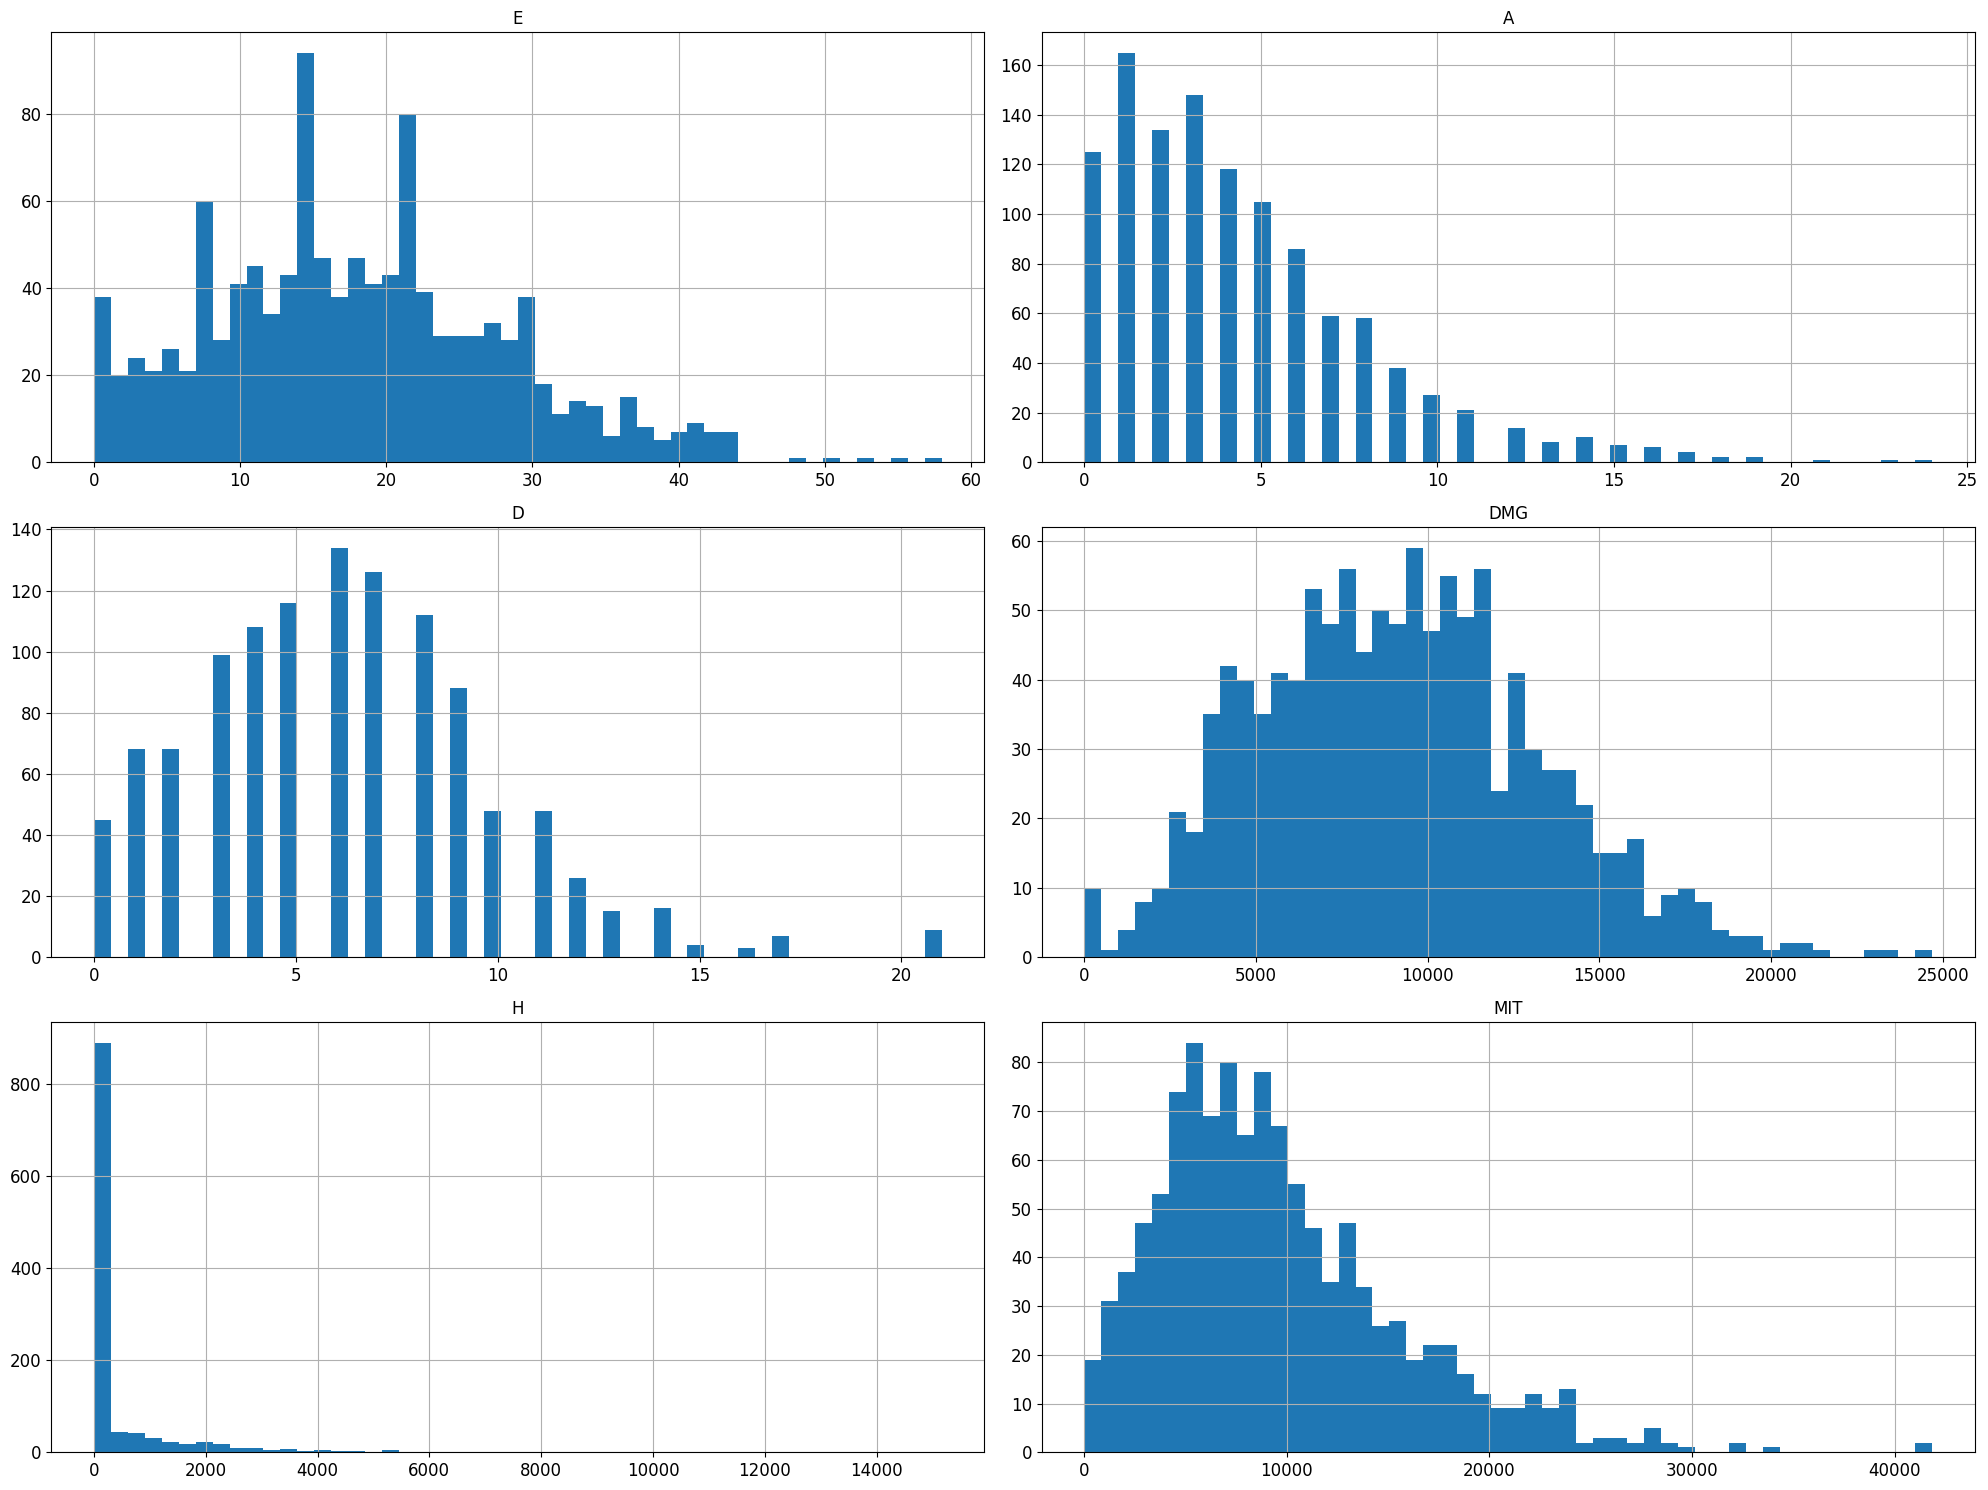

In [10]:
tank.hist(bins=50, figsize=(20, 15))
save_fig('tank_hist')
plt.show()

그림 저장:damage_hist


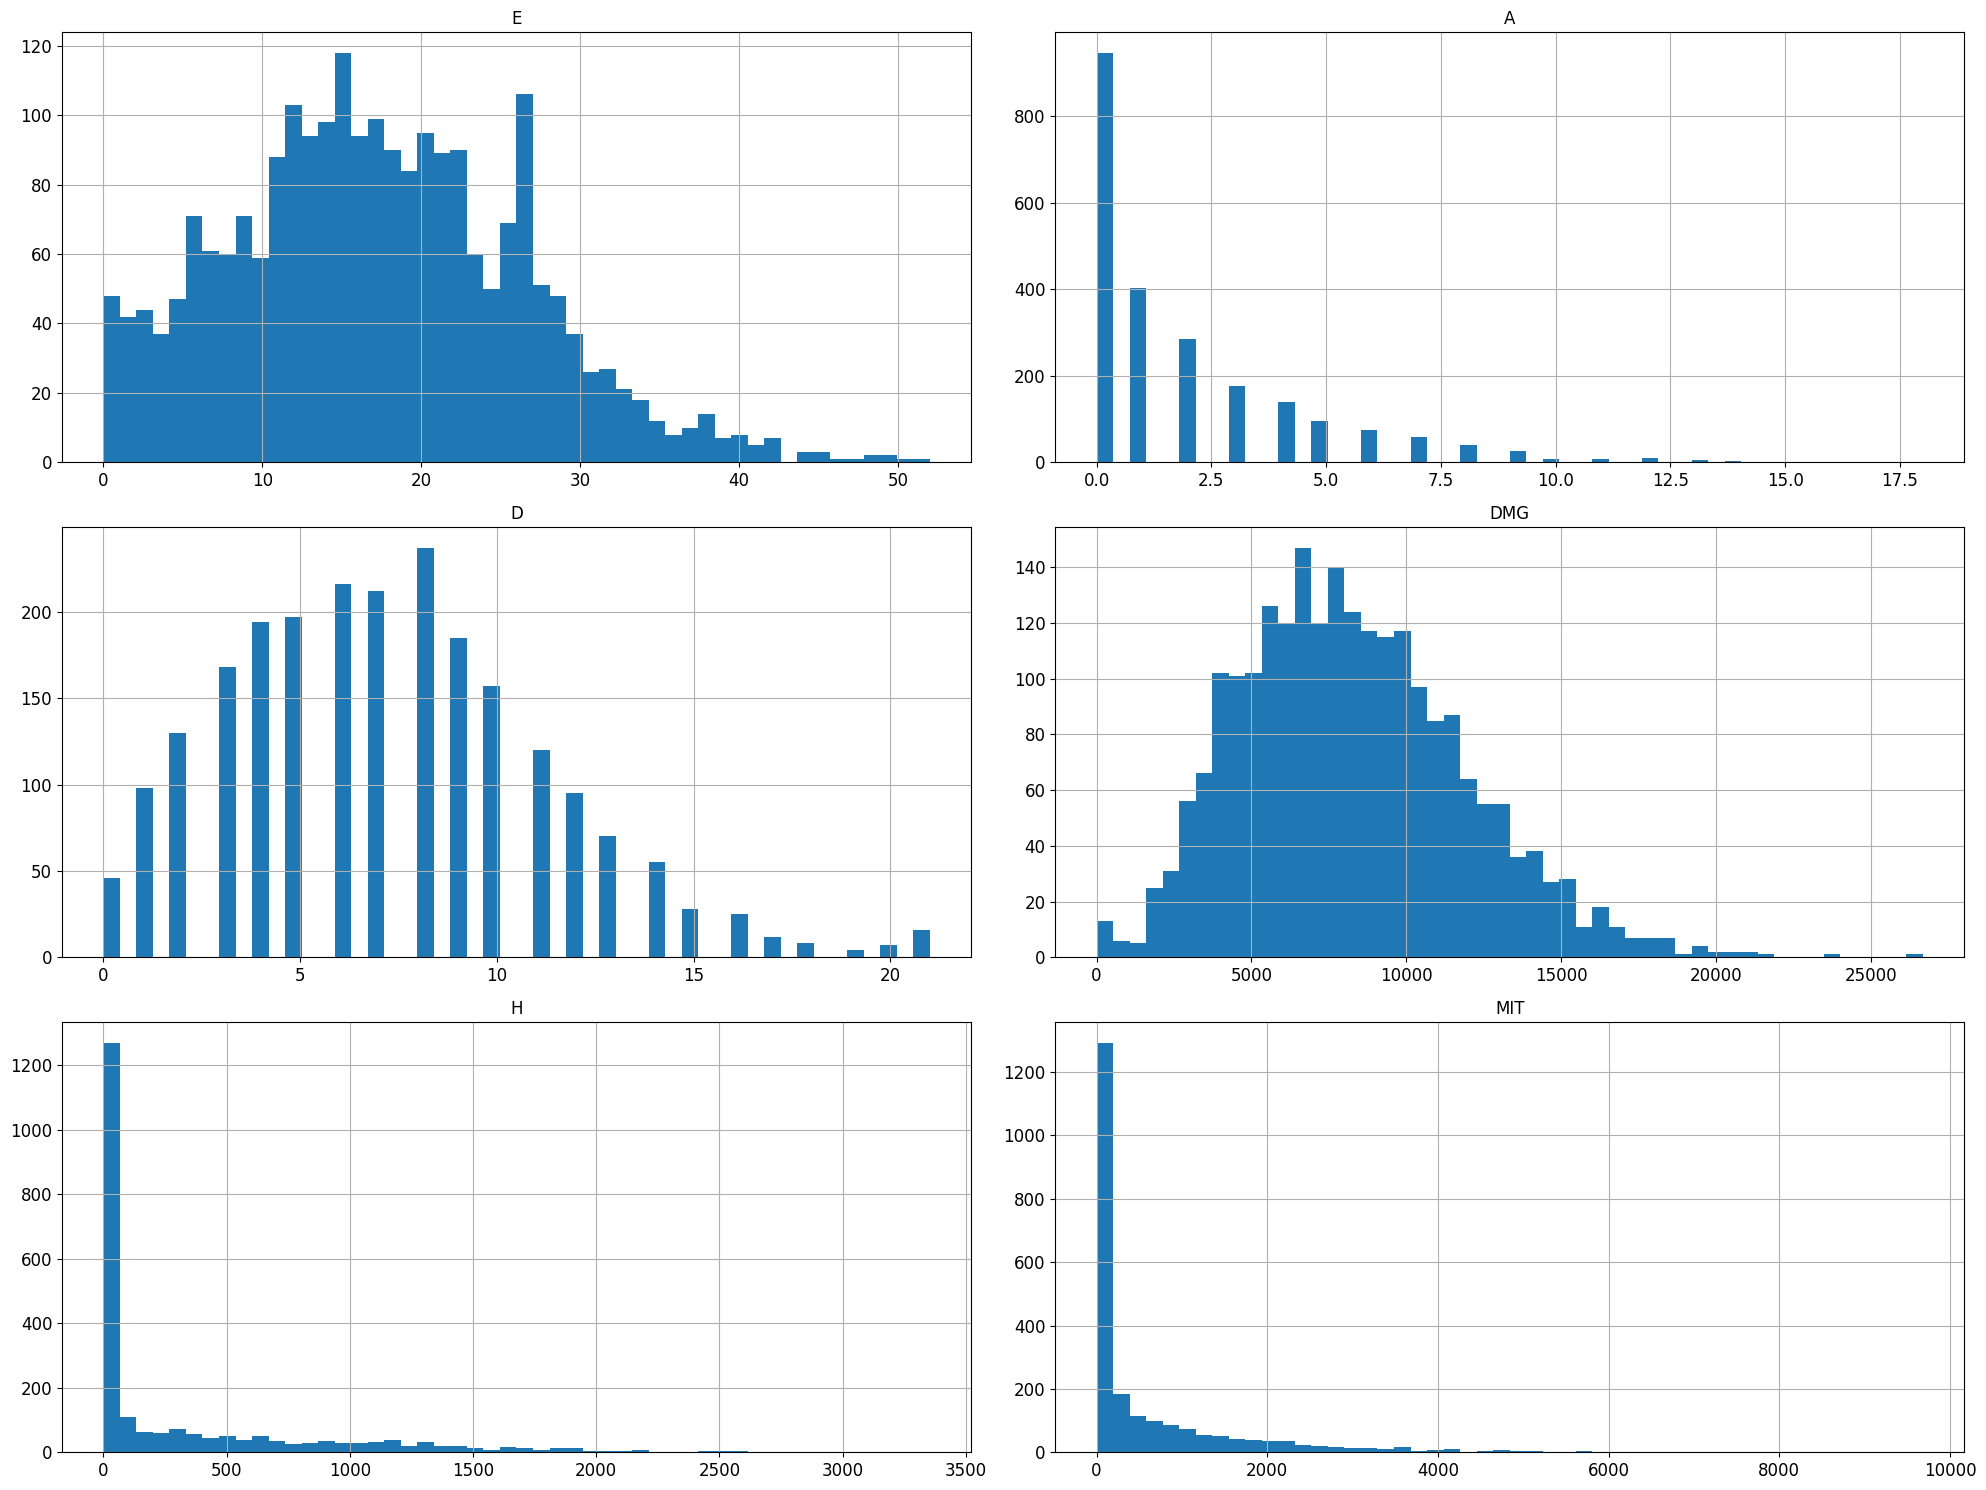

In [11]:
damage.hist(bins=50, figsize=(20, 15))
save_fig('damage_hist')
plt.show()

그림 저장:support_hist


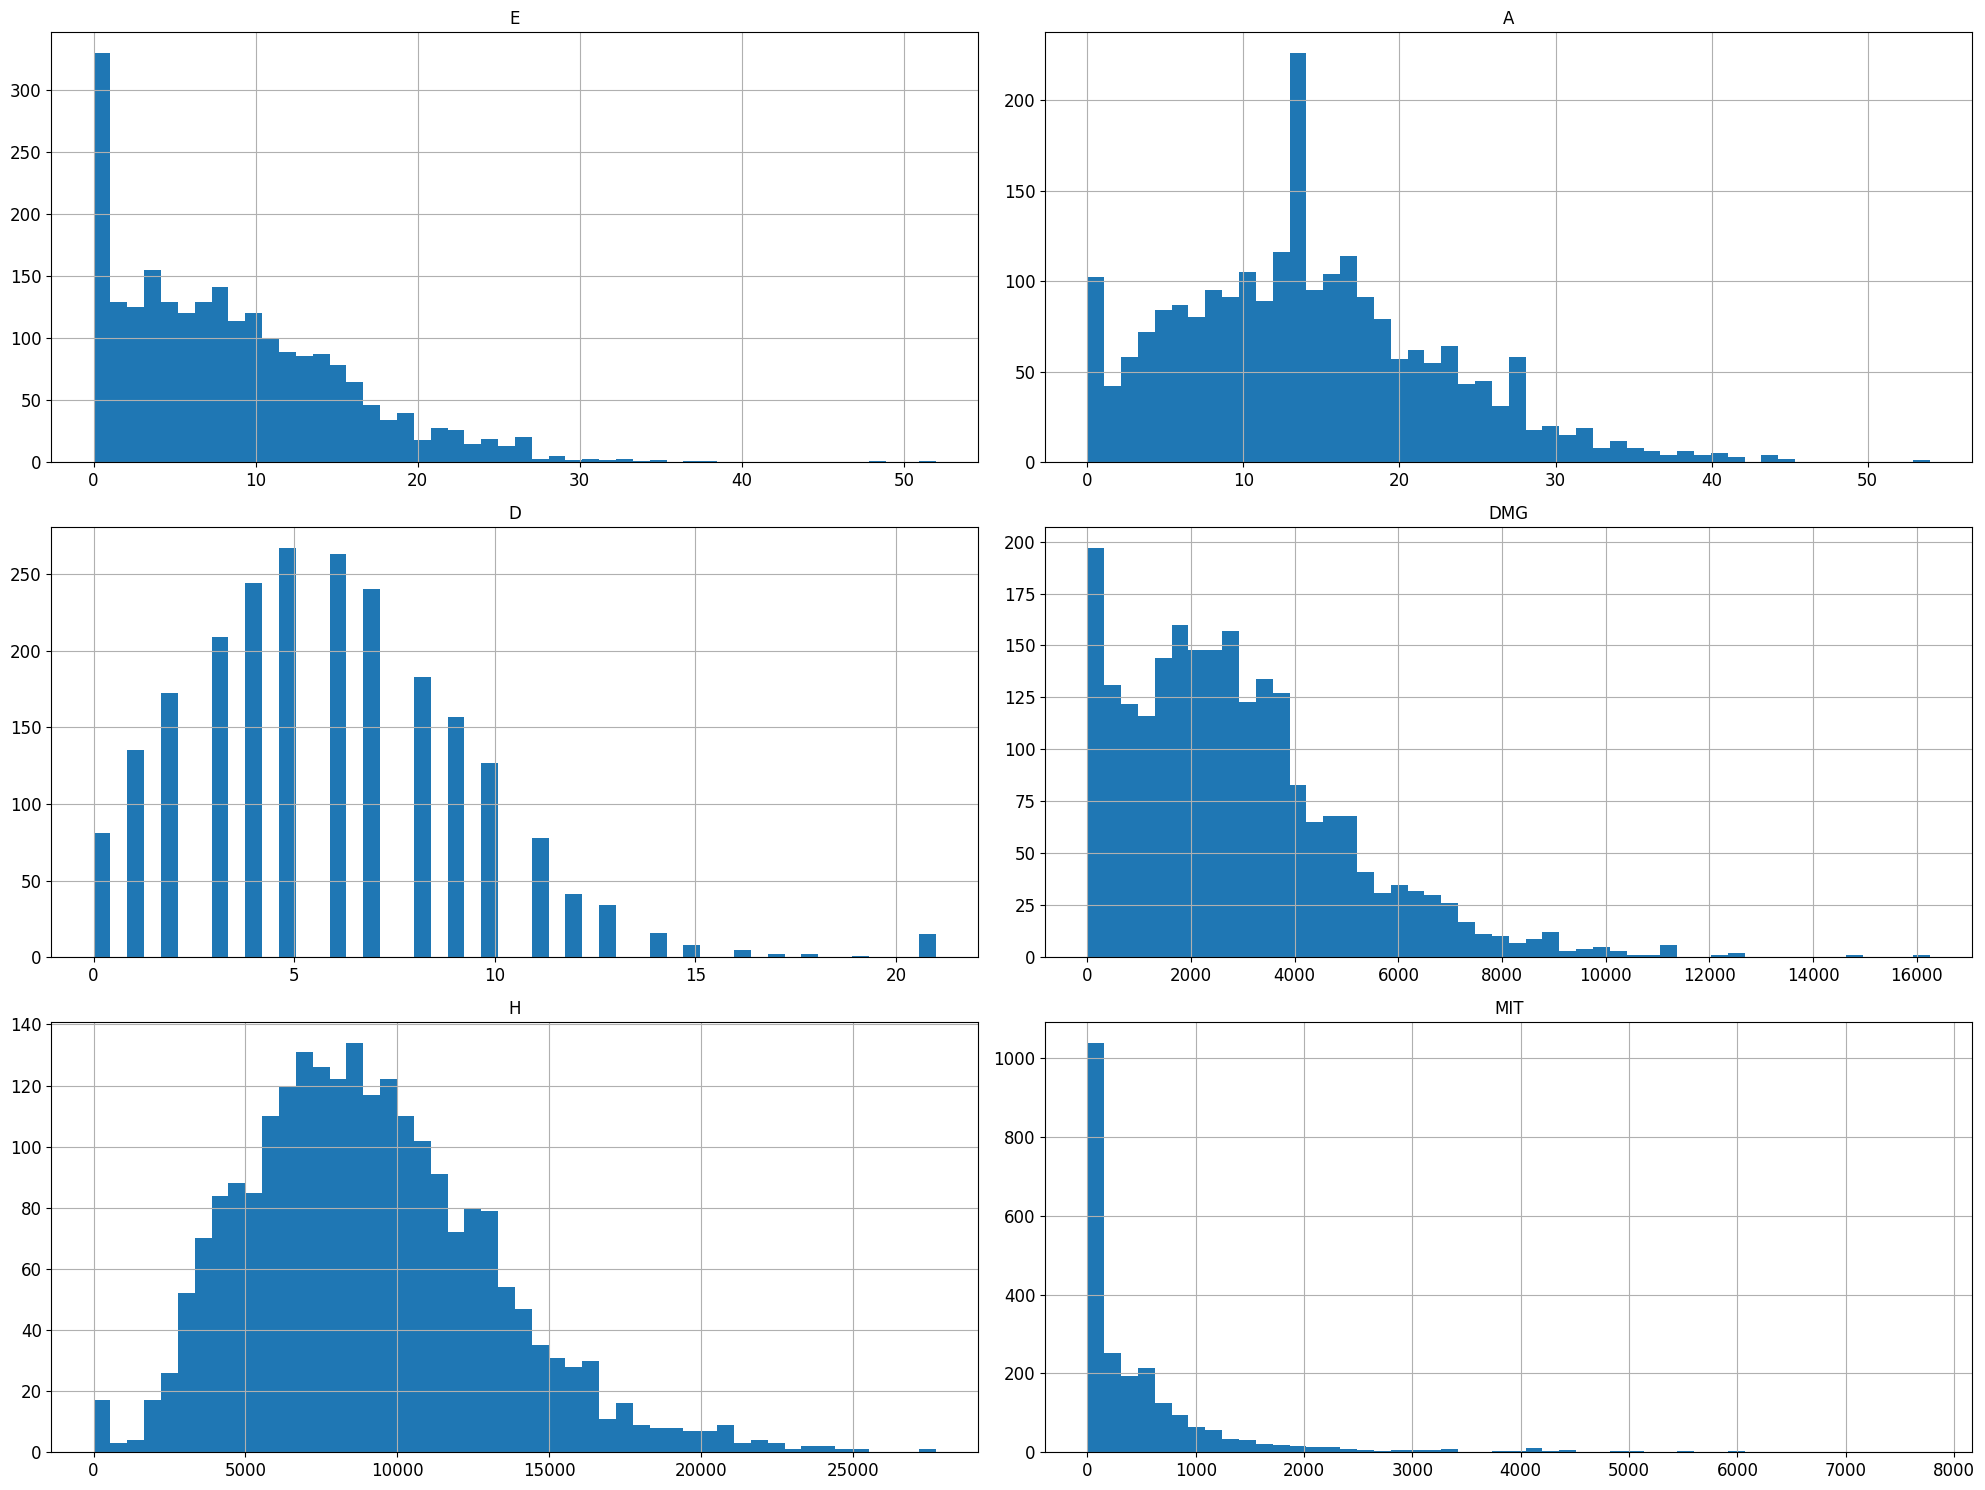

In [12]:
support.hist(bins=50, figsize=(20, 15))
save_fig('support_hist')
plt.show()

In [13]:
from sklearn import utils

scoreboards = scoreboards.loc[utils.shuffle(range(len(scoreboards.index) // players))]
scoreboards

E   A   D    DMG      H    MIT    GAME
75  0  18  10  10   9690      0  14347  DEFEAT
    1  27   0   4  12309      0      0  DEFEAT
    2  22   0  11  12685      0   3582  DEFEAT
    3  26  22   9   8377   9492   1318  DEFEAT
    4   0  23  10     21  13152      0  DEFEAT
...    ..  ..  ..    ...    ...    ...     ...
498 5  28   3   6  14238    968   2283  DEFEAT
    6  18   7   8  10633      0      0  DEFEAT
    7  25   2   9  11231    946   2283  DEFEAT
    8   8  17   6   2322  11849    463  DEFEAT
    9  17  22   9   6119   9399      0  DEFEAT

[5700 rows x 7 columns]

In [14]:
X = scoreboards.drop('GAME', axis=1)
y = scoreboards['GAME'][::players].copy()

In [15]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler().fit(X)
joblib.dump(scaler, 'scaler.joblib')
X = pd.DataFrame(scaler.transform(X), X.index, X.columns)
X

E         A         D       DMG         H       MIT
75  0  0.310345  0.185185  0.476190  0.363384  0.000000  0.342828
    1  0.465517  0.000000  0.190476  0.461599  0.000000  0.000000
    2  0.379310  0.000000  0.523810  0.475699  0.000000  0.085593
    3  0.448276  0.407407  0.428571  0.314145  0.341980  0.031494
    4  0.000000  0.425926  0.476190  0.000788  0.473843  0.000000
...         ...       ...       ...       ...       ...       ...
498 5  0.482759  0.055556  0.285714  0.533938  0.034875  0.054553
    6  0.310345  0.129630  0.380952  0.398747  0.000000  0.000000
    7  0.431034  0.037037  0.428571  0.421173  0.034083  0.054553
    8  0.137931  0.314815  0.285714  0.087077  0.426899  0.011064
    9  0.293103  0.407407  0.428571  0.229468  0.338629  0.000000

[5700 rows x 6 columns]

In [16]:
features = X.shape[-1]
total_features = players * features
X = X.values.reshape(-1, total_features)
print(X.shape)
print(y.shape)

(570, 60)
(570,)


In [17]:
from sklearn import model_selection, linear_model

cv_iter = 1600
model_selection.cross_val_score(linear_model.LogisticRegressionCV(max_iter=cv_iter), X, y)

array([0.87719298, 0.86842105, 0.85964912, 0.84210526, 0.85964912])

In [18]:
from sklearn import neighbors

radius = 2.
model_selection.cross_val_score(neighbors.RadiusNeighborsClassifier(radius), X, y)

array([0.52631579, 0.54385965, 0.56140351, 0.57017544, 0.54385965])

In [19]:
from sklearn import neural_network

classifier_iter = 3200
model_selection.cross_val_score(neural_network.MLPClassifier(max_iter=classifier_iter), X, y)

array([0.84210526, 0.88596491, 0.85087719, 0.85964912, 0.83333333])

In [20]:
from sklearn import ensemble, svm, tree
import operator

estimators = (
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(n_jobs=-1),
    ensemble.ExtraTreesClassifier(n_jobs=-1),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(n_jobs=-1),
    ensemble.HistGradientBoostingClassifier(),
    linear_model.LogisticRegression(n_jobs=-1),
    linear_model.LogisticRegressionCV(max_iter=cv_iter, n_jobs=-1),
    linear_model.PassiveAggressiveClassifier(n_jobs=-1),
    linear_model.Perceptron(n_jobs=-1),
    linear_model.RidgeClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(n_jobs=-1),
    neighbors.KNeighborsClassifier(n_jobs=-1),
    neighbors.RadiusNeighborsClassifier(radius, n_jobs=-1),
    neighbors.NearestCentroid(),
    neural_network.MLPClassifier(max_iter=classifier_iter),
    svm.LinearSVC(dual='auto'),
    svm.NuSVC(),
    svm.SVC(),
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier()
)
scores = [(estimator, model_selection.cross_val_score(estimator, X, y, n_jobs=-1).mean()) for estimator in estimators]
scores.sort(key=operator.itemgetter(1), reverse=True)
scores

[(LogisticRegression(n_jobs=-1), 0.8789473684210526),
 (RidgeClassifier(), 0.8789473684210526),
 (RidgeClassifierCV(), 0.8789473684210526),
 (LinearSVC(dual='auto'), 0.8736842105263157),
 (MLPClassifier(max_iter=3200), 0.8666666666666668),
 (NearestCentroid(), 0.8649122807017544),
 (NuSVC(), 0.8649122807017544),
 (SVC(), 0.8631578947368421),
 (LogisticRegressionCV(max_iter=1600, n_jobs=-1), 0.8614035087719298),
 (ExtraTreesClassifier(n_jobs=-1), 0.8526315789473685),
 (RandomForestClassifier(n_jobs=-1), 0.8508771929824561),
 (SGDClassifier(n_jobs=-1), 0.8491228070175438),
 (HistGradientBoostingClassifier(), 0.8473684210526315),
 (GradientBoostingClassifier(), 0.8385964912280702),
 (KNeighborsClassifier(n_jobs=-1), 0.8333333333333333),
 (PassiveAggressiveClassifier(n_jobs=-1), 0.8263157894736842),
 (BaggingClassifier(n_jobs=-1), 0.8192982456140351),
 (AdaBoostClassifier(), 0.8122807017543859),
 (DecisionTreeClassifier(), 0.775438596491228),
 (ExtraTreeClassifier(), 0.7508771929824561),
 

In [21]:
defeats = len(defeat) // players


def find_file(index):
    index += 1
    if index <= defeats:
        return f'DEFEAT ({index})'
    else:
        index -= len(victory) // players
        return f'VICTORY ({index})'

In [22]:
for estimator, _ in scores:
    estimator = estimator.fit(X, y)
    if hasattr(estimator, 'feature_importances_'):
        importances = estimator.feature_importances_.reshape(-1, features)
        tanks, damages, supports = [0, 5], [1, 2, 6, 7], [3, 4, 8, 9]
        importances_tank = importances[tanks].sum(0)
        importances_damage = importances[damages].sum(0)
        importances_support = importances[supports].sum(0)
        importances[tanks] = importances_tank / 2
        importances[damages] = importances_damage / 4
        importances[supports] = importances_support / 4
        joblib.dump(importances, 'importances.joblib')

        titles = '처치', '도움', '죽음', '피해', '치유', '경감'

        print('**특성 중요도**')
        for importance, title in sorted(zip(importances.sum(0), titles), reverse=True):
            print(f'{title}: {importance:.2f}')

        print('\n**1인 역할 중요도**')
        for importance, title in sorted(
                zip(
                    (importances_tank.sum(), importances_damage.sum() / 2, importances_support.sum() / 2),
                    ('돌격', '공격', '지원')
                ),
                reverse=True
        ):
            print(f'{title}: {importance:.2f}')

        print('\n**1인 돌격 특성 중요도**')
        for importance, title in sorted(zip(importances_tank, titles), reverse=True):
            print(f'{title}: {importance:.2f}')

        print('\n**1인 공격 특성 중요도**')
        for importance, title in sorted(zip(importances_damage / 2, titles), reverse=True):
            print(f'{title}: {importance:.2f}')

        print('\n**1인 지원 특성 중요도**')
        for importance, title in sorted(zip(importances_support / 2, titles), reverse=True):
            print(f'{title}: {importance:.2f}')

        break

**특성 중요도**
처치: 0.27
죽음: 0.26
도움: 0.19
피해: 0.10
경감: 0.09
치유: 0.08

**1인 역할 중요도**
돌격: 0.25
지원: 0.19
공격: 0.18

**1인 돌격 특성 중요도**
죽음: 0.08
처치: 0.07
도움: 0.04
피해: 0.02
경감: 0.02
치유: 0.02

**1인 공격 특성 중요도**
처치: 0.07
죽음: 0.04
피해: 0.02
도움: 0.02
경감: 0.02
치유: 0.02

**1인 지원 특성 중요도**
도움: 0.06
죽음: 0.05
처치: 0.03
경감: 0.02
치유: 0.02
피해: 0.02


In [23]:
defeats = defeat.index.stop
for i in range(defeats - 10, defeats - 101, -players):
    defeat_i = defeat[i:i + players]
    print(f'DEFEAT ({i // players + 1})')
    print(defeat_i)
    contributions = scaler.transform(defeat_i.drop(['GAME'], axis=1))
    contributions[:, 2] = 1 - contributions[:, 2]
    contributions *= importances
    contributions = contributions.sum(1)
    contributions[tanks] *= 2 / contributions[tanks].sum()
    contributions[damages] *= 4 / contributions[damages].sum()
    contributions[supports] *= 4 / contributions[supports].sum()
    print(f'TEAM 1:', end='')
    for contribution in contributions[:5]:
        print(f' {contribution:.2f}', end='')
    print(f'\nTEAM 2:', end='')
    for contribution in contributions[5:]:
        print(f' {contribution:.2f}', end='')
    print('\n')

DEFEAT (258)
       E   A   D    DMG      H    MIT     GAME
2570  14   0  15  11660    575   9859   DEFEAT
2571  13   5  14  11285     70    185   DEFEAT
2572  14   1  11  11700      0   1049   DEFEAT
2573   8   6   6   5923  10606   1076   DEFEAT
2574  10  11  10   6944  10458      0   DEFEAT
2575  24   5   6  13229      0  18015  VICTORY
2576  26   2  10  10378      0    965  VICTORY
2577  36   0   8  14436      0    882  VICTORY
2578  17  22   5   3543  14959    975  VICTORY
2579  17  36   6   4994  10994      0  VICTORY
TEAM 1: 0.67 0.70 0.81 0.79 0.75
TEAM 2: 1.33 1.08 1.40 1.15 1.31

DEFEAT (257)
       E   A  D    DMG      H    MIT     GAME
2560  17   3  6  10904      0  13384   DEFEAT
2561  15   0  3  11176      0      0   DEFEAT
2562  14   3  7  13342   1146   2037   DEFEAT
2563   4   9  8   2028   9788    534   DEFEAT
2564   2  17  4    368  13413      0   DEFEAT
2565  22  12  2  12560      0   9258  VICTORY
2566  19   2  7   9857    348      0  VICTORY
2567  11   1  6  10355

In [24]:
victorys = victory.index.stop
for i in range(victorys - 10, victorys - 101, -players):
    victory_i = victory[i:i + players]
    print(f'VICTORY ({i // players + 1})')
    print(victory_i)
    contributions = scaler.transform(victory_i.drop(['GAME'], axis=1))
    contributions[:, 2] = 1 - contributions[:, 2]
    contributions *= importances
    contributions = contributions.sum(1)
    contributions[tanks] *= 2 / contributions[tanks].sum()
    contributions[damages] *= 4 / contributions[damages].sum()
    contributions[supports] *= 4 / contributions[supports].sum()
    print(f'TEAM 1:', end='')
    for contribution in contributions[:5]:
        print(f' {contribution:.2f}', end='')
    print(f'\nTEAM 2:', end='')
    for contribution in contributions[5:]:
        print(f' {contribution:.2f}', end='')
    print('\n')

VICTORY (312)
       E   A   D    DMG      H   MIT     GAME
3110  26   2   8  14800   5388  4351   DEFEAT
3111  24   0   9  11956      0   556   DEFEAT
3112  19   3  11   7131      0   826   DEFEAT
3113  13  21   5   4697  12149   385   DEFEAT
3114  29  21   8  11112  11465     0   DEFEAT
3115  19   4   8  11908    505  6656  VICTORY
3116  21   1   8   9786      0    51  VICTORY
3117  20   5  11  13060      0     0  VICTORY
3118  21  17   6  10272  15807     0  VICTORY
3119  14  16  12   4702  11242  1129  VICTORY
TEAM 1: 1.06 1.10 0.87 1.04 1.12
TEAM 2: 0.94 1.04 0.99 1.09 0.76

VICTORY (311)
       E   A   D    DMG      H   MIT     GAME
3100  21   4   7  12780    825  4303   DEFEAT
3101  22   2   6   8502      0     0   DEFEAT
3102  30   1   7  13246   1396     0   DEFEAT
3103  14  21   3   3951   8655   384   DEFEAT
3104  12  22   6   4414   5711   133   DEFEAT
3105  17   3   8   9623   1083  8271  VICTORY
3106  23   2   9   7611      0     0  VICTORY
3107  12   3  10   8167     46 

In [25]:
from tensorflow.keras import backend, layers
from tensorflow import keras

backend.clear_session()
model = keras.Sequential()
model.add(layers.Dense(300, 'relu', input_shape=(total_features,)))
model.add(layers.Dense(100, 'relu'))
model.add(layers.Dense(1, 'sigmoid'))
model.summary()

2024-02-22 06:43:27.700882: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-22 06:43:29.012554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 06:43:29.027327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 06:43:29.027594: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been bu

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               18300     
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 48501 (189.46 KB)
Trainable params: 48501 (189.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
from tensorflow.keras import optimizers, callbacks

model.compile('sgd', 'binary_crossentropy', ['accuracy'])
transform = preprocessing.LabelEncoder().fit_transform(y)
stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    X,
    transform,
    epochs=256,
    callbacks=[stopping],
    validation_split=.25
)
history.history['val_loss'][-11], history.history['val_accuracy'][-11]

Epoch 1/256


2024-02-22 06:43:29.908661: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-22 06:43:29.938247: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7a38e40600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-22 06:43:29.938284: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-02-22 06:43:29.961226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-02-22 06:43:29.970497: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-22 06:43:30.008383: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 [==============================] - 1s 14ms/step - loss: 0.6904 - accuracy: 0.5386 - val_loss: 0.6829 - val_accuracy: 0.6643
Epoch 2/256
14/14 [==============================] - 0s 5ms/step - loss: 0.6810 - accuracy: 0.7096 - val_loss: 0.6740 - val_accuracy: 0.6993
Epoch 3/256
14/14 [==============================] - 0s 5ms/step - loss: 0.6724 - accuracy: 0.7518 - val_loss: 0.6652 - val_accuracy: 0.8042
Epoch 4/256
14/14 [==============================] - 0s 5ms/step - loss: 0.6635 - accuracy: 0.8103 - val_loss: 0.6566 - val_accuracy: 0.8462
Epoch 5/256
14/14 [==============================] - 0s 5ms/step - loss: 0.6551 - accuracy: 0.8361 - val_loss: 0.6484 - val_accuracy: 0.8671
Epoch 6/256
14/14 [==============================] - 0s 5ms/step - loss: 0.6471 - accuracy: 0.8431 - val_loss: 0.6402 - val_accuracy: 0.8811
Epoch 7/256
14/14 [==============================] - 0s 5ms/step - loss: 0.6393 - accuracy: 0.8478 - val_loss: 0.6322 - val_accuracy: 0.8811
Epoch 8/256
14/14 [=====

(0.2834172248840332, 0.8741258978843689)